# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:

from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs682.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8]
regularization_strengths = [1e5, 3e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lrs in learning_rates:
    for rgs in regularization_strengths:
        print("Now training with ",lrs, rgs)
        svm = LinearSVM()
        loss_histogram = svm.train(X_train_feats, y_train, lrs, rgs, num_iters=3000, batch_size = 180, verbose=True)
        y_train_predict = svm.predict(X_train_feats)
        train_accuracy = np.mean( y_train_predict == y_train )
        y_valid_predict = svm.predict(X_val_feats)
        valid_accuracy = np.mean(y_val == y_valid_predict)
        results[(lrs,rgs)] = (train_accuracy,valid_accuracy)
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lrs, rgs in sorted(results):
    train_accuracy, val_accuracy = results[(lrs, rgs)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lrs, rgs, train_accuracy, val_accuracy))
    
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Now training with  1e-09 100000.0
iteration 0 / 3000: loss 163.052256
iteration 100 / 3000: loss 157.030201
iteration 200 / 3000: loss 151.212391
iteration 300 / 3000: loss 145.646446
iteration 400 / 3000: loss 140.284682
iteration 500 / 3000: loss 135.143294
iteration 600 / 3000: loss 130.178628
iteration 700 / 3000: loss 125.445767
iteration 800 / 3000: loss 120.875571
iteration 900 / 3000: loss 116.491324
iteration 1000 / 3000: loss 112.275294
iteration 1100 / 3000: loss 108.220704
iteration 1200 / 3000: loss 104.331105
iteration 1300 / 3000: loss 100.598684
iteration 1400 / 3000: loss 96.997859
iteration 1500 / 3000: loss 93.537855
iteration 1600 / 3000: loss 90.232486
iteration 1700 / 3000: loss 87.052481
iteration 1800 / 3000: loss 83.987164
iteration 1900 / 3000: loss 81.037509
iteration 2000 / 3000: loss 78.227869
iteration 2100 / 3000: loss 75.503988
iteration 2200 / 3000: loss 72.904106
iteration 2300 / 3000: loss 70.393084
iteration 2400 / 3000: loss 67.984350
iteration 2500

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


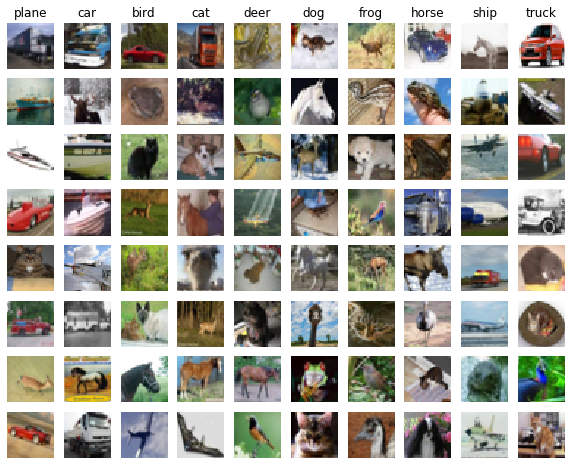

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

There are quite a few misclassifications like a horse is classified in the class plane which is probably because of the blue background behind the horse that the classifier got baffled with as the sky which can be considerable but there are various other cases too. For instance, the dog in the first row has been classified in the truck class which is utter disappointment and can't be considered at all.
Hence apart from the hues of the pixels and the edge densities, we still need some more features for the classifier to work even more efficiently.


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [15]:
from cs682.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None
best_val = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
lr = [1.5e-1, 0.9]
reg = [4.5e-5, 4.5e-6, 4.5e-7]
hidden = [250, 450, 800]
for lrs in lr:
    for rg in reg:
        for h in hidden:
            neural_net = TwoLayerNet(input_dim, h, num_classes)
            stats = neural_net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=1000, batch_size=200,
                        learning_rate=lrs, learning_rate_decay=0.95,
                        reg=rg, verbose=True)
            val_accuracy = np.mean((neural_net.predict(X_val_feats) == y_val))
            print('validation accuracy: %f' % val_accuracy)

            # Save best values
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_net = neural_net
print('best validation accuracy: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.294691
iteration 200 / 1000: loss 1.757715
iteration 300 / 1000: loss 1.576042
iteration 400 / 1000: loss 1.423999
iteration 500 / 1000: loss 1.364638
iteration 600 / 1000: loss 1.346439
iteration 700 / 1000: loss 1.290926
iteration 800 / 1000: loss 1.287046
iteration 900 / 1000: loss 1.280389
validation accuracy: 0.520000
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.286215
iteration 200 / 1000: loss 1.803412
iteration 300 / 1000: loss 1.466084
iteration 400 / 1000: loss 1.378187
iteration 500 / 1000: loss 1.475742
iteration 600 / 1000: loss 1.247634
iteration 700 / 1000: loss 1.314885
iteration 800 / 1000: loss 1.399427
iteration 900 / 1000: loss 1.399570
validation accuracy: 0.529000
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.274302
iteration 200 / 1000: loss 1.814955
iteration 300 / 1000: loss 1.640738
iteration 400 / 1000: loss 1.435925
iteration 500 / 1000: loss 1.288410
iteration 

In [19]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.549
